# **Preprocess and Expoore MIMIC-III Patient Lab Data and Diagnoses**
____

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import MinMaxScaler

In [2]:
path_mimic = "C:\mimic-iii-clinical-database-1.4"

### **Step 1: Load Data**
### Import LABEVENTS.csv

In [3]:
df_labevents = pd.read_csv(os.path.join(path_mimic,"LABEVENTS.csv.gz"))
print(df_labevents.shape)
df_labevents.head()

(27854055, 9)


,ROW_ID,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,VALUEUOM,FLAG
0,281,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,units,NaN
1,282,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,NaN
2,283,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,mEq/L,NaN
3,284,3,NaN,50804,2101-10-12 18:17:00,22,22.00,mEq/L,NaN
4,285,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,mmol/L,abnormal


### Import D_LABITEMS.csv

In [4]:
df_labitems = pd.read_csv(os.path.join(path_mimic,"D_LABITEMS.csv.gz"))
print(df_labitems.shape)
df_labitems.head()

(753, 6)


,ROW_ID,ITEMID,LABEL,FLUID,CATEGORY,LOINC_CODE
0,546,51346,Blasts,Cerebrospinal Fluid (CSF),Hematology,26447-3
1,547,51347,Eosinophils,Cerebrospinal Fluid (CSF),Hematology,26451-5
2,548,51348,"Hematocrit, CSF",Cerebrospinal Fluid (CSF),Hematology,30398-2
3,549,51349,Hypersegmented Neutrophils,Cerebrospinal Fluid (CSF),Hematology,26506-6
4,550,51350,Immunophenotyping,Cerebrospinal Fluid (CSF),Hematology,NaN


### Import DIAGNOSES_ICD.csv

In [5]:
df_diagnoses = pd.read_csv(os.path.join(path_mimic,"DIAGNOSES_ICD.csv.gz"))
print(df_diagnoses.shape)
df_diagnoses.head()

(651047, 5)


,ROW_ID,SUBJECT_ID,HADM_ID,SEQ_NUM,ICD9_CODE
0,1297,109,172335,1.0,40301
1,1298,109,172335,2.0,486
2,1299,109,172335,3.0,58281
3,1300,109,172335,4.0,5855
4,1301,109,172335,5.0,4254


### Import D_ICD_DIAGNOSES.csv

In [6]:
df_icd9 = pd.read_csv(os.path.join(path_mimic,"D_ICD_DIAGNOSES.csv.gz"))
print(df_icd9.shape)
df_icd9.head()

(14567, 4)


,ROW_ID,ICD9_CODE,SHORT_TITLE,LONG_TITLE
0,174,01166,TB pneumonia-oth test,"Tuberculous pneumonia [any form], tubercle bac..."
1,175,01170,TB pneumothorax-unspec,"Tuberculous pneumothorax, unspecified"
2,176,01171,TB pneumothorax-no exam,"Tuberculous pneumothorax, bacteriological or h..."
3,177,01172,TB pneumothorx-exam unkn,"Tuberculous pneumothorax, bacteriological or h..."
4,178,01173,TB pneumothorax-micro dx,"Tuberculous pneumothorax, tubercle bacilli fou..."


### **Step 2: Merge All data by SUBJECT_ID**

In [7]:
# Merge labevents with d_labitems to get the label of each lab test
lab_data = pd.merge(df_labevents.drop(columns=['VALUEUOM', 'ROW_ID']), df_labitems.loc[:, ['ITEMID', 'LABEL']], on='ITEMID')
lab_data.head()

,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,FLAG,LABEL
0,3,NaN,50820,2101-10-12 16:07:00,7.39,7.39,NaN,pH
1,3,NaN,50800,2101-10-12 18:17:00,ART,NaN,NaN,SPECIMEN TYPE
2,3,NaN,50802,2101-10-12 18:17:00,-1,-1.00,NaN,Base Excess
3,3,NaN,50804,2101-10-12 18:17:00,22,22.00,NaN,Calculated Total CO2
4,3,NaN,50808,2101-10-12 18:17:00,0.93,0.93,abnormal,Free Calcium


In [8]:
diag_data = pd.merge(df_diagnoses[df_diagnoses['SEQ_NUM'] == 1.].drop(columns=['ROW_ID', 'SEQ_NUM']), df_icd9.drop(columns=['ROW_ID', 'LONG_TITLE']), on='ICD9_CODE')
diag_data.head()

,SUBJECT_ID,HADM_ID,ICD9_CODE,SHORT_TITLE
0,109,172335,40301,Mal hyp kid w cr kid V
1,109,173633,40301,Mal hyp kid w cr kid V
2,112,174105,53100,Ac stomach ulcer w hem
3,113,109976,1915,Mal neo cereb ventricle
4,114,178393,41401,Crnry athrscl natve vssl


### Filter Tests that may be of interest for mental health

In [9]:
# Filter for specific lab tests using their labels
relevant_tests = ['Sodium', 'Serum Sodium', 'Na',
    'Potassium', 'Serum Potassium', 'K',
    'Chloride', 'Serum Chloride', 'Cl',
    'Bicarbonate', 'Serum Bicarbonate', 'CO2', 'HCO3',
    'BUN', 'Urea Nitrogen',
    'Creatinine', 'Serum Creatinine',
    'Glucose', 'Serum Glucose', 'Blood Glucose',
    'WBC', 'White Blood Cell Count', 'Leukocyte Count',
    'RBC', 'Red Blood Cell Count', 'Erythrocyte Count',
    'Hemoglobin', 'Hgb',
    'Hematocrit', 'Hct',
    'Platelets', 'Platelet Count',
    'TSH',
    'Free T4', 'FT4',
    'Free T3', 'FT3',
    'ALT', 'SGPT',
    'AST', 'SGOT',
    'Alkaline Phosphatase',
    'Bilirubin', 'Total Bilirubin',
    'Albumin',
    'Lithium level',
    'Valproate level', 'Valproic Acid level',
    'Clozapine level',
    'Vitamin D', '25-hydroxy Vitamin D',
    'Vitamin B12',
    'CRP']
filtered_data = lab_data[lab_data['LABEL'].isin(relevant_tests)]
print(filtered_data.shape)

(9003746, 8)


In [10]:
# Drop rows where the main lab value is missing
clean_data = filtered_data.dropna(subset=['VALUENUM'])

scaler = MinMaxScaler()

# Apply normalization within each lab test group
clean_data['normalized_valuenum'] = clean_data.groupby('ITEMID')['VALUENUM'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())

clean_data['CHARTTIME'] = pd.to_datetime(clean_data['CHARTTIME'])

# Sort data by subject and time
clean_data = clean_data.sort_values(by=['SUBJECT_ID', 'CHARTTIME'])
print(clean_data.shape)

C:\Users\khngu\AppData\Local\Temp\ipykernel_33960\2813179623.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['normalized_valuenum'] = clean_data.groupby('ITEMID')['VALUENUM'].transform(lambda x: scaler.fit_transform(x.values.reshape(-1, 1)).flatten())
C:\Users\khngu\AppData\Local\Temp\ipykernel_33960\2813179623.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  clean_data['CHARTTIME'] = pd.to_datetime(clean_data['CHARTTIME'])


(8729554, 9)


### **Step 3: Extract Additional Features**
- Rolling mean
- Rolling standard deviation
- Minimum and maximum
- Change from baseline

In [11]:
clean_data['rolling_mean'] = clean_data.groupby('SUBJECT_ID')['normalized_valuenum'].transform(lambda x: x.rolling(window=3, min_periods=1).mean())
clean_data['rolling_std'] = clean_data.groupby('SUBJECT_ID')['normalized_valuenum'].transform(lambda x: x.rolling(window=3, min_periods=1).std())
clean_data['max_value'] = clean_data.groupby('SUBJECT_ID')['normalized_valuenum'].transform(lambda x: x.rolling(window=3, min_periods=1).max())
clean_data['min_value'] = clean_data.groupby('SUBJECT_ID')['normalized_valuenum'].transform(lambda x: x.rolling(window=3, min_periods=1).min())
clean_data['change_from_baseline'] = clean_data.groupby('SUBJECT_ID')['normalized_valuenum'].transform(lambda x: x - x.iloc[0])
clean_data.head()

,SUBJECT_ID,HADM_ID,ITEMID,CHARTTIME,VALUE,VALUENUM,FLAG,LABEL,normalized_valuenum,rolling_mean,rolling_std,max_value,min_value,change_from_baseline
599,2,163353.0,51221,2138-07-17 20:48:00,0,0.0,abnormal,Hematocrit,0.000000,0.000000,NaN,0.000000,0.000000,0.000000
600,2,163353.0,51222,2138-07-17 20:48:00,0,0.0,abnormal,Hemoglobin,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
609,2,163353.0,51265,2138-07-17 20:48:00,5,5.0,abnormal,Platelet Count,0.000222,0.000074,0.000128,0.000222,0.000000,0.000222
618,2,163353.0,51221,2138-07-17 21:10:00,49.6,49.6,NaN,Hematocrit,0.638353,0.212858,0.368489,0.638353,0.000000,0.638353
619,2,163353.0,51222,2138-07-17 21:10:00,16.5,16.5,abnormal,Hemoglobin,0.647059,0.428545,0.370964,0.647059,0.000222,0.647059


### **Step 4: Data Visualization**
### Visualize Monthly Average of Creatinine Levels

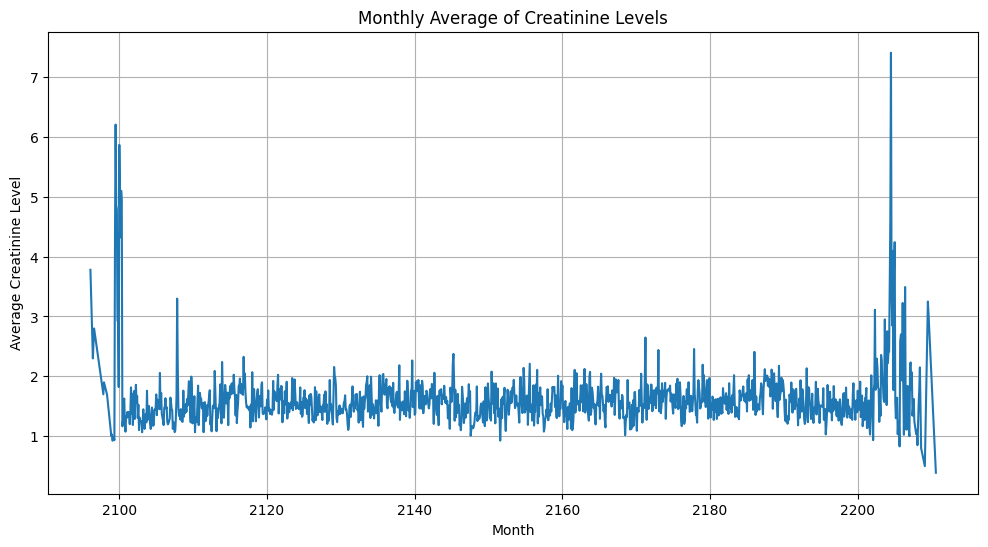

In [12]:
# Assuming 'charttime' and 'valuenum' are already in the correct format
clean_data['month'] = clean_data['CHARTTIME'].dt.to_period('M')

# Calculate monthly averages
monthly_averages = clean_data[clean_data['LABEL'] == 'Creatinine'].groupby('month')['VALUENUM'].mean().reset_index()

# Plotting
plt.figure(figsize=(12, 6))
plt.plot(monthly_averages['month'].dt.to_timestamp(), monthly_averages['VALUENUM'])
plt.title('Monthly Average of Creatinine Levels')
plt.xlabel('Month')
plt.ylabel('Average Creatinine Level')
plt.grid(True)
plt.show()

# Distribution of Creatinine, Red Blood Cells (RBC), and Hemoglobin Levels

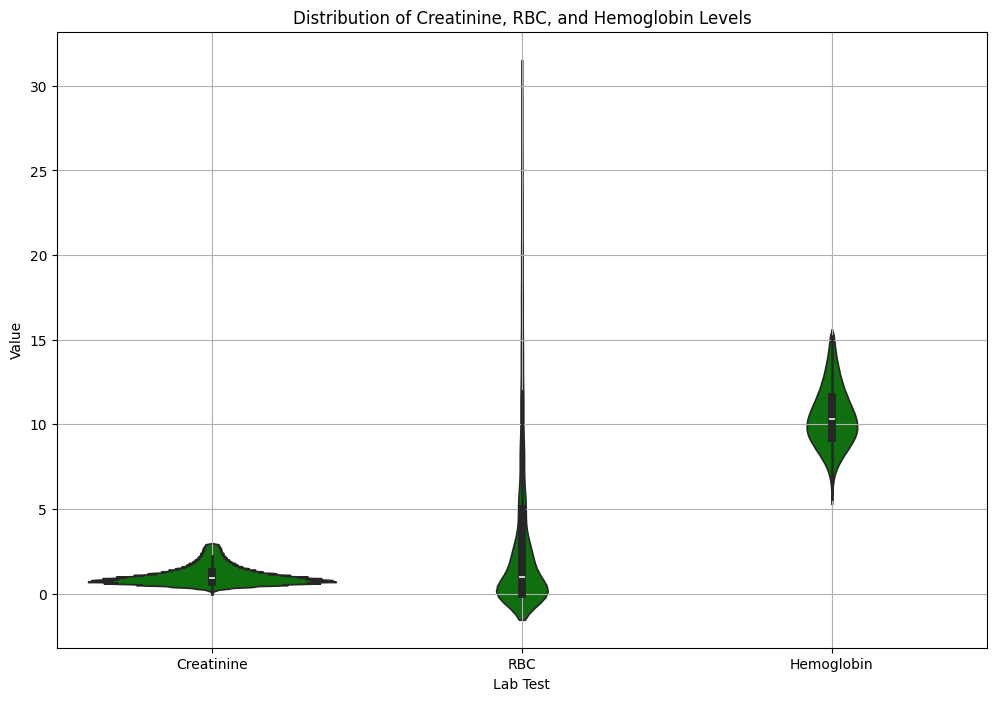

In [13]:
# Function to remove outliers using IQR
def remove_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

# Apply the function to each lab test
creatinine_data = remove_outliers(clean_data[clean_data['LABEL'] == 'Creatinine'], 'VALUENUM')
rbc_data = remove_outliers(clean_data[clean_data['LABEL'] == 'RBC'], 'VALUENUM')
tsh_data = remove_outliers(clean_data[clean_data['LABEL'] == 'Hemoglobin'], 'VALUENUM')

plt.figure(figsize=(12, 8))
sns.violinplot(x='LABEL', y='VALUENUM', data=pd.concat([creatinine_data, rbc_data, tsh_data]), color='g')
plt.title('Distribution of Creatinine, RBC, and Hemoglobin Levels')
plt.xlabel('Lab Test')
plt.ylabel('Value')
plt.grid(True)
plt.show()

# Heatmap of Lab Values for 100 Random Patients' Priority (main) Diagnosis

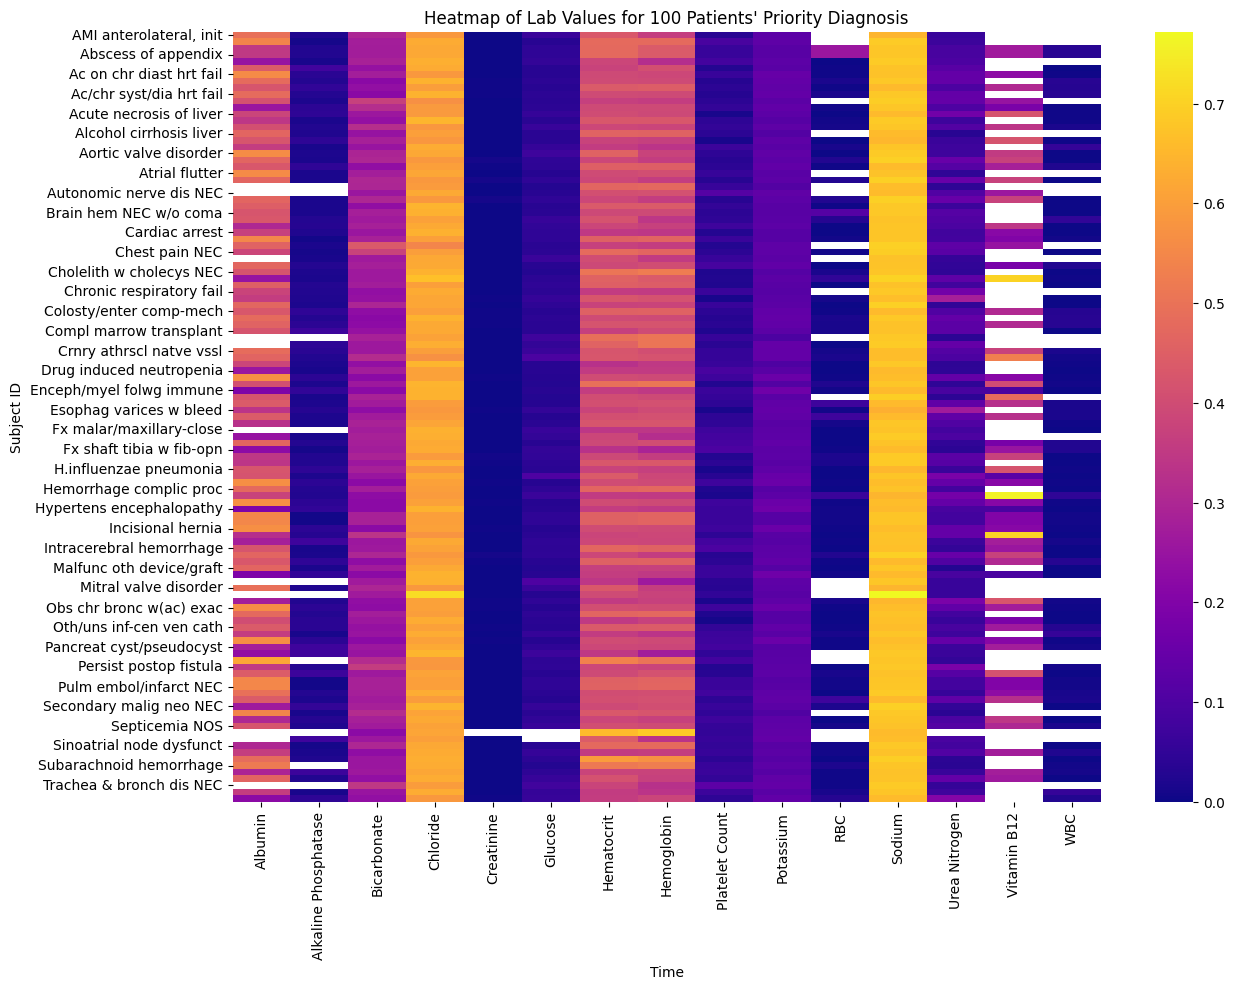

In [14]:
# Sample a subset of patients
sample_data = clean_data[clean_data['SUBJECT_ID'].isin(clean_data['SUBJECT_ID'].sample(100))]
sample_data = pd.merge(sample_data, diag_data.drop(columns=['HADM_ID']), on=['SUBJECT_ID'])

# Pivot the data to create a heatmap
pivot_table = sample_data.pivot_table(index='SHORT_TITLE', columns='LABEL', values='normalized_valuenum', aggfunc='mean')

plt.figure(figsize=(14, 10))
sns.heatmap(pivot_table, cmap='plasma')
plt.title("Heatmap of Lab Values for 100 Patients' Priority Diagnosis")
plt.xlabel('Time')
plt.ylabel('Subject ID')
plt.show()

In [15]:
sample_data.to_csv('diagnoses_lab.csv')